In [2]:
import yaml
import os
from towbintools.foundation import file_handling as file_handling
import pandas as pd

import numpy as np
import argparse
import matplotlib.pyplot as plt

from towbintools.data_analysis import compute_growth_rate_per_larval_stage, correct_series_with_classification, filter_series_with_classification, compute_larval_stage_duration, rescale_and_aggregate, compute_series_at_time_classified

from scipy import interpolate
import seaborn as sns
import starbars
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu

from scipy.signal import savgol_filter, medfilt
from towbintools.foundation.utils import interpolate_nans

from plotting_functions import plot_aggregated_series, plot_correlation, plot_correlation_at_molt, boxplot_at_molt, plot_growth_curves_individuals, plot_deviation_from_model_at_ecdysis, plot_normalized_proportions, plot_deviation_from_model

In [3]:
# filemap_path = "/mnt/towbin.data/shared/kstojanovski/20240625_Orca_10x_yap-1aid-raga-1aid_wBT186-437-438-439_25C_20240625_154359_670/analysis/report/analysis_filemap_annotated.csv"
# config_path = '../config.yaml'

filemap_path = "/mnt/towbin.data/shared/spsalmon/20240823_SQUID_10x_yap1_del_dpy/analysis/report/analysis_filemap_annotated.csv"
config_path = "/mnt/towbin.data/shared/spsalmon/20240823_SQUID_10x_yap1_del_dpy/analysis/report/config/config_dpy.yaml"

experiment_filemap = pd.read_csv(filemap_path)
experiment_filemap.head()

organ_channels = {'body' : 2, 'pharynx' : 1}

In [4]:
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    file.close()

def build_conditions(config):
    conditions = []
    condition_id = 0

    for condition in config["conditions"]:
        condition = {key: [val] if not isinstance(val, list) else val for key, val in condition.items()}

        lengths = set(len(val) for val in condition.values())
        if len(lengths) > 2 or (len(lengths) == 2 and 1 not in lengths):
            raise ValueError("All lists in the condition must have the same length or be of length 1.")

        max_length = max(lengths)
        for i in range(max_length):
            condition_dict = {
                key: val[0] if len(val) == 1 else val[i]
                for key, val in condition.items()
            }
            condition_dict["condition_id"] = condition_id
            conditions.append(condition_dict)
            condition_id += 1

    return conditions
    
conditions = build_conditions(config)
print(conditions)

conditions_keys = list(conditions[0].keys())

# remove 'point_range' and 'pad' from the conditions keys if they are present
if 'point_range' in conditions_keys:
    conditions_keys.remove('point_range')
if 'pad' in conditions_keys:
    conditions_keys.remove('pad')

[{'rnai': 'EV', 'strain': 'wBT160', 'point_range': [0, 27], 'condition_id': 0}, {'rnai': 'EV', 'strain': 'wBT415', 'point_range': [59, 68], 'condition_id': 1}, {'rnai': 'dpy-1', 'strain': 'wBT160', 'point_range': [28, 58], 'condition_id': 2}, {'rnai': 'dpy-1', 'strain': 'wBT415', 'point_range': [69, 86], 'condition_id': 3}]


In [5]:
experiment_filemap.columns

Index(['Time', 'Point', 'raw', 'ExperimentTime', 'analysis/ch1_seg',
       'analysis/ch2_seg', 'analysis/ch2_seg_str', 'analysis/ch1_seg_str',
       'analysis/ch1_ch2_ch3_raw_str', 'ch2_seg_str_volume',
       'ch2_seg_str_length', 'ch2_seg_str_area', 'ch1_seg_str_volume',
       'ch1_seg_str_length', 'ch1_seg_str_area', 'ch2_seg_str_worm_type',
       'HatchTime', 'ch2_seg_str_volume_at_HatchTime', 'M1',
       'ch2_seg_str_volume_at_M1', 'M2', 'ch2_seg_str_volume_at_M2', 'M3',
       'ch2_seg_str_volume_at_M3', 'M4', 'ch2_seg_str_volume_at_M4',
       'ch1_seg_str_volume_at_M3', 'ch1_seg_str_volume_at_M4',
       'ch2_seg_str_length_at_M3', 'ch2_seg_str_length_at_M4',
       'ch1_seg_str_length_at_M3', 'ch1_seg_str_length_at_M4',
       'ch2_seg_str_area_at_M3', 'ch2_seg_str_area_at_M4',
       'ch1_seg_str_area_at_M3', 'ch1_seg_str_area_at_M4',
       'ch1_seg_str_volume_at_M1', 'ch2_seg_str_length_at_M1',
       'ch1_seg_str_length_at_M1', 'ch2_seg_str_area_at_M1',
       'ch1_se

In [6]:
def add_conditions_to_filemap(experiment_filemap, conditions, config):
    for condition in conditions:
        if "point_range" in condition.keys():
            point_range = condition["point_range"]
            # Get all the rows that are in the point range
            condition_rows = experiment_filemap[experiment_filemap["Point"].between(point_range[0], point_range[1])]
            # Remove the point range from the condition
            conditions_to_add = {key: val for key, val in condition.items() if key != "point_range"}
            for key, val in conditions_to_add.items():
                # Directly fill the rows with the value for the new or existing column
                experiment_filemap.loc[condition_rows.index, key] = val

        elif "pad" in condition.keys():
            pad = condition["pad"]
            # Get all the rows that are in the pad
            condition_rows = experiment_filemap[experiment_filemap["Pad"] == pad]
            # Remove the pad from the condition
            conditions_to_add = {key: val for key, val in condition.items() if key != "pad"}
            for key, val in conditions_to_add.items():
                # Directly fill the rows with the value for the new or existing column
                experiment_filemap.loc[condition_rows.index, key] = val
                
        else:
            print("Condition does not contain 'point_range' or 'pad' key, impossible to add condition to filemap, skipping.")
    return experiment_filemap

experiment_filemap = add_conditions_to_filemap(experiment_filemap, conditions, config)
experiment_filemap.columns

Index(['Time', 'Point', 'raw', 'ExperimentTime', 'analysis/ch1_seg',
       'analysis/ch2_seg', 'analysis/ch2_seg_str', 'analysis/ch1_seg_str',
       'analysis/ch1_ch2_ch3_raw_str', 'ch2_seg_str_volume',
       'ch2_seg_str_length', 'ch2_seg_str_area', 'ch1_seg_str_volume',
       'ch1_seg_str_length', 'ch1_seg_str_area', 'ch2_seg_str_worm_type',
       'HatchTime', 'ch2_seg_str_volume_at_HatchTime', 'M1',
       'ch2_seg_str_volume_at_M1', 'M2', 'ch2_seg_str_volume_at_M2', 'M3',
       'ch2_seg_str_volume_at_M3', 'M4', 'ch2_seg_str_volume_at_M4',
       'ch1_seg_str_volume_at_M3', 'ch1_seg_str_volume_at_M4',
       'ch2_seg_str_length_at_M3', 'ch2_seg_str_length_at_M4',
       'ch1_seg_str_length_at_M3', 'ch1_seg_str_length_at_M4',
       'ch2_seg_str_area_at_M3', 'ch2_seg_str_area_at_M4',
       'ch1_seg_str_area_at_M3', 'ch1_seg_str_area_at_M4',
       'ch1_seg_str_volume_at_M1', 'ch2_seg_str_length_at_M1',
       'ch1_seg_str_length_at_M1', 'ch2_seg_str_area_at_M1',
       'ch1_se

In [7]:
experiment_filemap["condition_id"].unique()

array([0., 2., 1., 3.])

In [8]:
conditions_struct = []

def get_ecdysis_and_durations(filemap):
    all_ecdysis_time_step = []
    all_durations_time_step = []

    all_ecdysis_experiment_time = []
    all_durations_experiment_time = []
    
    for point in filemap["Point"].unique():
        point_df = filemap[filemap["Point"] == point]
        point_ecdysis = point_df[["HatchTime", "M1", "M2", "M3", "M4"]].iloc[0]
        larval_stage_durations = list(compute_larval_stage_duration(point_ecdysis).values())

        point_ecdysis = point_ecdysis.to_numpy()
        all_ecdysis_time_step.append(point_ecdysis)
        all_durations_time_step.append(larval_stage_durations)

        ecdysis_experiment_time = []
        for ecdys in point_ecdysis:
            if np.isnan(ecdys):
                ecdysis_experiment_time.append(np.nan)
            else:
                ecdys_experiment_time = point_df[point_df["Time"] == ecdys]["ExperimentTime"].iloc[0]
                ecdysis_experiment_time.append(ecdys_experiment_time)

        all_ecdysis_experiment_time.append(ecdysis_experiment_time)
        
        durations_experiment_time = []
        for i in range(len(ecdysis_experiment_time) - 1):
            start = ecdysis_experiment_time[i]
            end = ecdysis_experiment_time[i + 1]
            duration_experiment_time = end - start
            durations_experiment_time.append(duration_experiment_time)

        all_durations_experiment_time.append(durations_experiment_time)
        
    return np.array(all_ecdysis_time_step), np.array(all_durations_time_step), np.array(all_ecdysis_experiment_time), np.array(all_durations_experiment_time)

def separate_column_by_point(filemap, column):
    separated_column = []
    for point in filemap["Point"].unique():
        point_df = filemap[filemap["Point"] == point]
        separated_column.append(point_df[column].values)
    return np.array(separated_column)
        
for condition_id in experiment_filemap["condition_id"].unique():
    condition_df = experiment_filemap[experiment_filemap["condition_id"] == condition_id]
    condition_dict = {}

    for key in conditions_keys:
        condition_dict[key] = condition_df[key].iloc[0]

    ecdysis_time_step, larval_stage_durations_time_step, ecdysis_experiment_time, larval_stage_durations_experiment_time = get_ecdysis_and_durations(condition_df)
    condition_dict['ecdysis_time_step'] = ecdysis_time_step
    condition_dict['larval_stage_durations_time_step'] = larval_stage_durations_time_step
    condition_dict['ecdysis_experiment_time'] = ecdysis_experiment_time
    condition_dict['larval_stage_durations_experiment_time'] = larval_stage_durations_experiment_time

    worm_type_column = [col for col in condition_df.columns if 'worm_type' in col][0]
    worm_types = separate_column_by_point(condition_df, worm_type_column)

    for organ in organ_channels.keys():
        organ_channel = organ_channels[organ]
        organ_channel = f'ch{organ_channel}'
        organ_columns = [col for col in condition_df.columns if col.startswith(organ_channel)]
        organ_columns = [col for col in organ_columns if not ('_at_' in col)]
        renamed_organ_columns = [col.replace(organ_channel, organ) for col in organ_columns]

        for organ_column, renamed_organ_column in zip(organ_columns, renamed_organ_columns):
            condition_dict[renamed_organ_column] = separate_column_by_point(condition_df, organ_column)

        # remove any column with worm_type in it
        renamed_organ_columns = [col for col in renamed_organ_columns if not ('worm_type' in col)]
        for column in renamed_organ_columns:
            condition_dict[f'{column}_at_ecdysis'] = np.stack([compute_series_at_time_classified(condition_dict[column][i], worm_types[i], ecdysis_time_step[i]) for i in range(len(ecdysis_time_step))])


    condition_dict['time'] = separate_column_by_point(condition_df, 'Time').astype(float)
    condition_dict['experiment_time'] = separate_column_by_point(condition_df, 'ExperimentTime').astype(float)

    conditions_struct.append(condition_dict)

Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returni

/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/towbintools/data_analysis/time_series.py:251: RuntimeWarning: Mean of empty slice
  aggregated_series[i, :] = aggregation_function(all_points_interpolated_series[:, i, :], axis=0)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


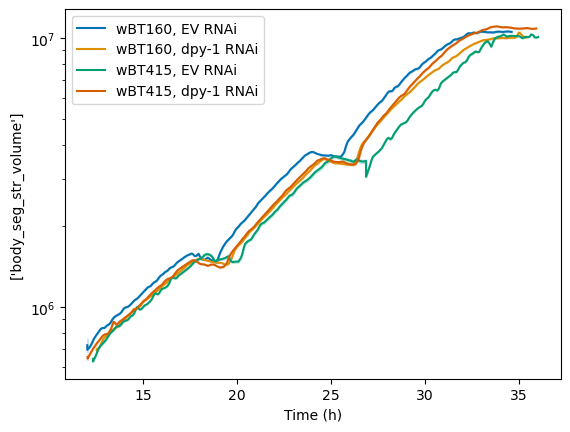

In [9]:
plot_aggregated_series(conditions_struct, ['body_seg_str_volume'], [0, 1, 2, 3], experiment_time = False, aggregation='mean', n_points=100, time_step = 10, log_scale = True, legend = {'strain': '', 'rnai': 'RNAi'})

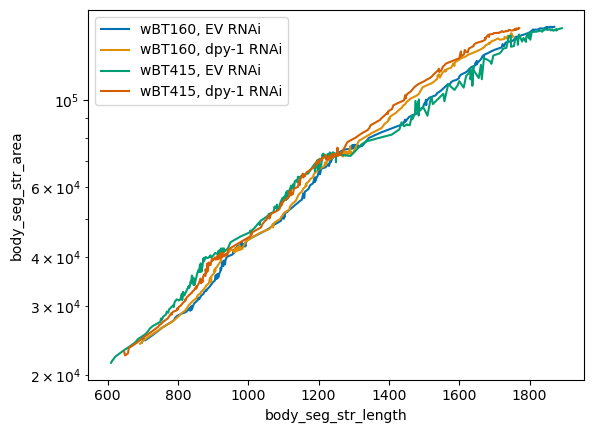

In [10]:
plot_correlation(conditions_struct, 'body_seg_str_length', 'body_seg_str_area', [0, 1, 2, 3], log_scale = (False, True), legend = {'strain': '', 'rnai': 'RNAi'})

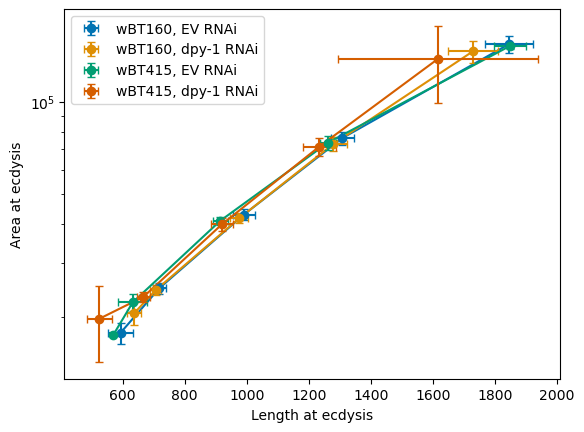

In [11]:
plot_correlation_at_molt(conditions_struct, 'body_seg_str_length_at_ecdysis', 'body_seg_str_area_at_ecdysis', [0, 1, 2, 3], log_scale = (False, True), legend = {'strain': '', 'rnai': 'RNAi'}, y_axis_label='Area at ecdysis', x_axis_label='Length at ecdysis')

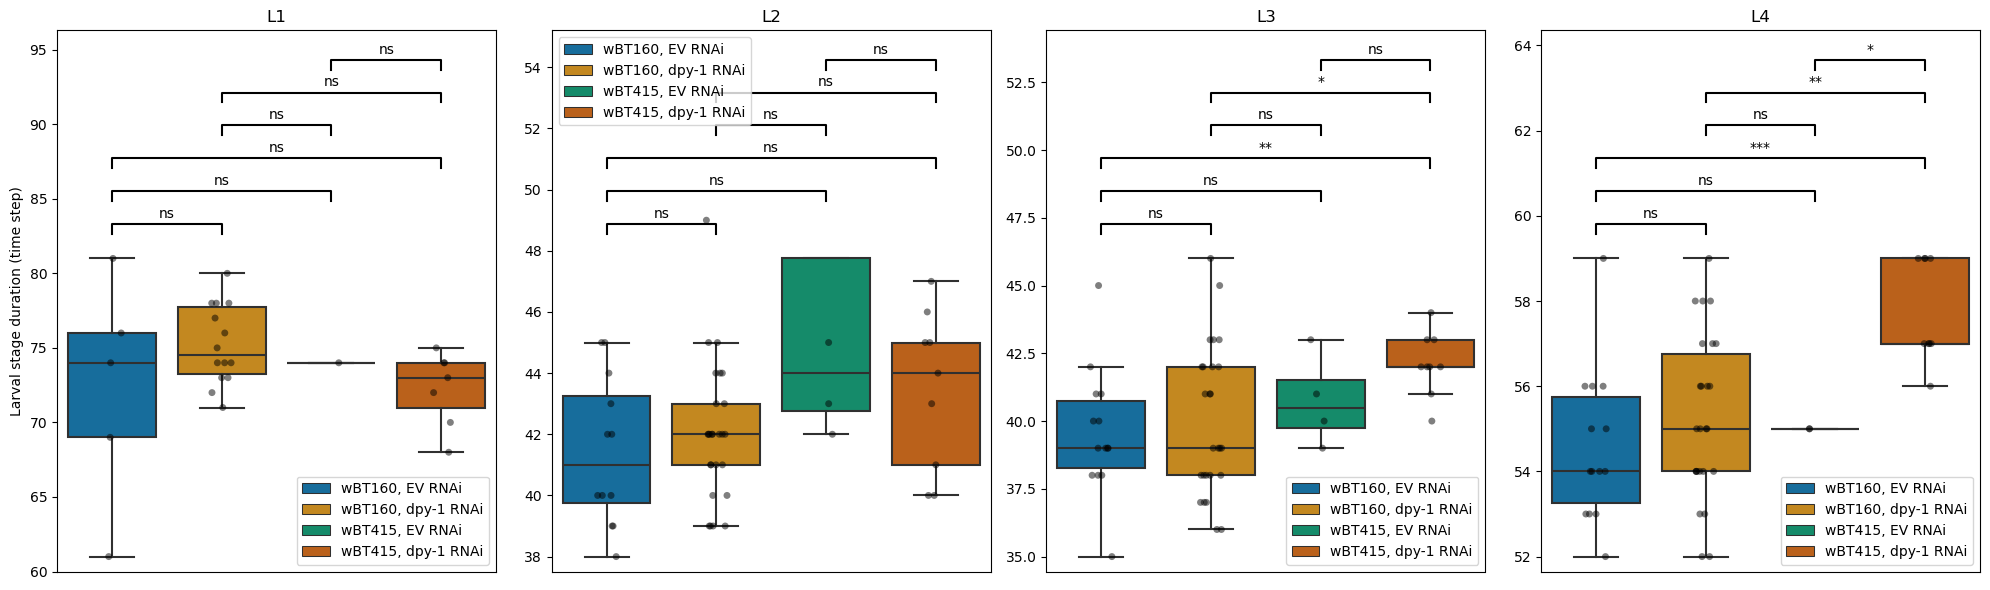

In [12]:
boxplot_at_molt(conditions_struct, 'larval_stage_durations_time_step', [0, 1, 2, 3], log_scale = False, plot_significance=True, legend = {'strain': '', 'rnai': 'RNAi'}, y_axis_label="Larval stage duration (time step)", titles = ['L1', 'L2', 'L3', 'L4'])

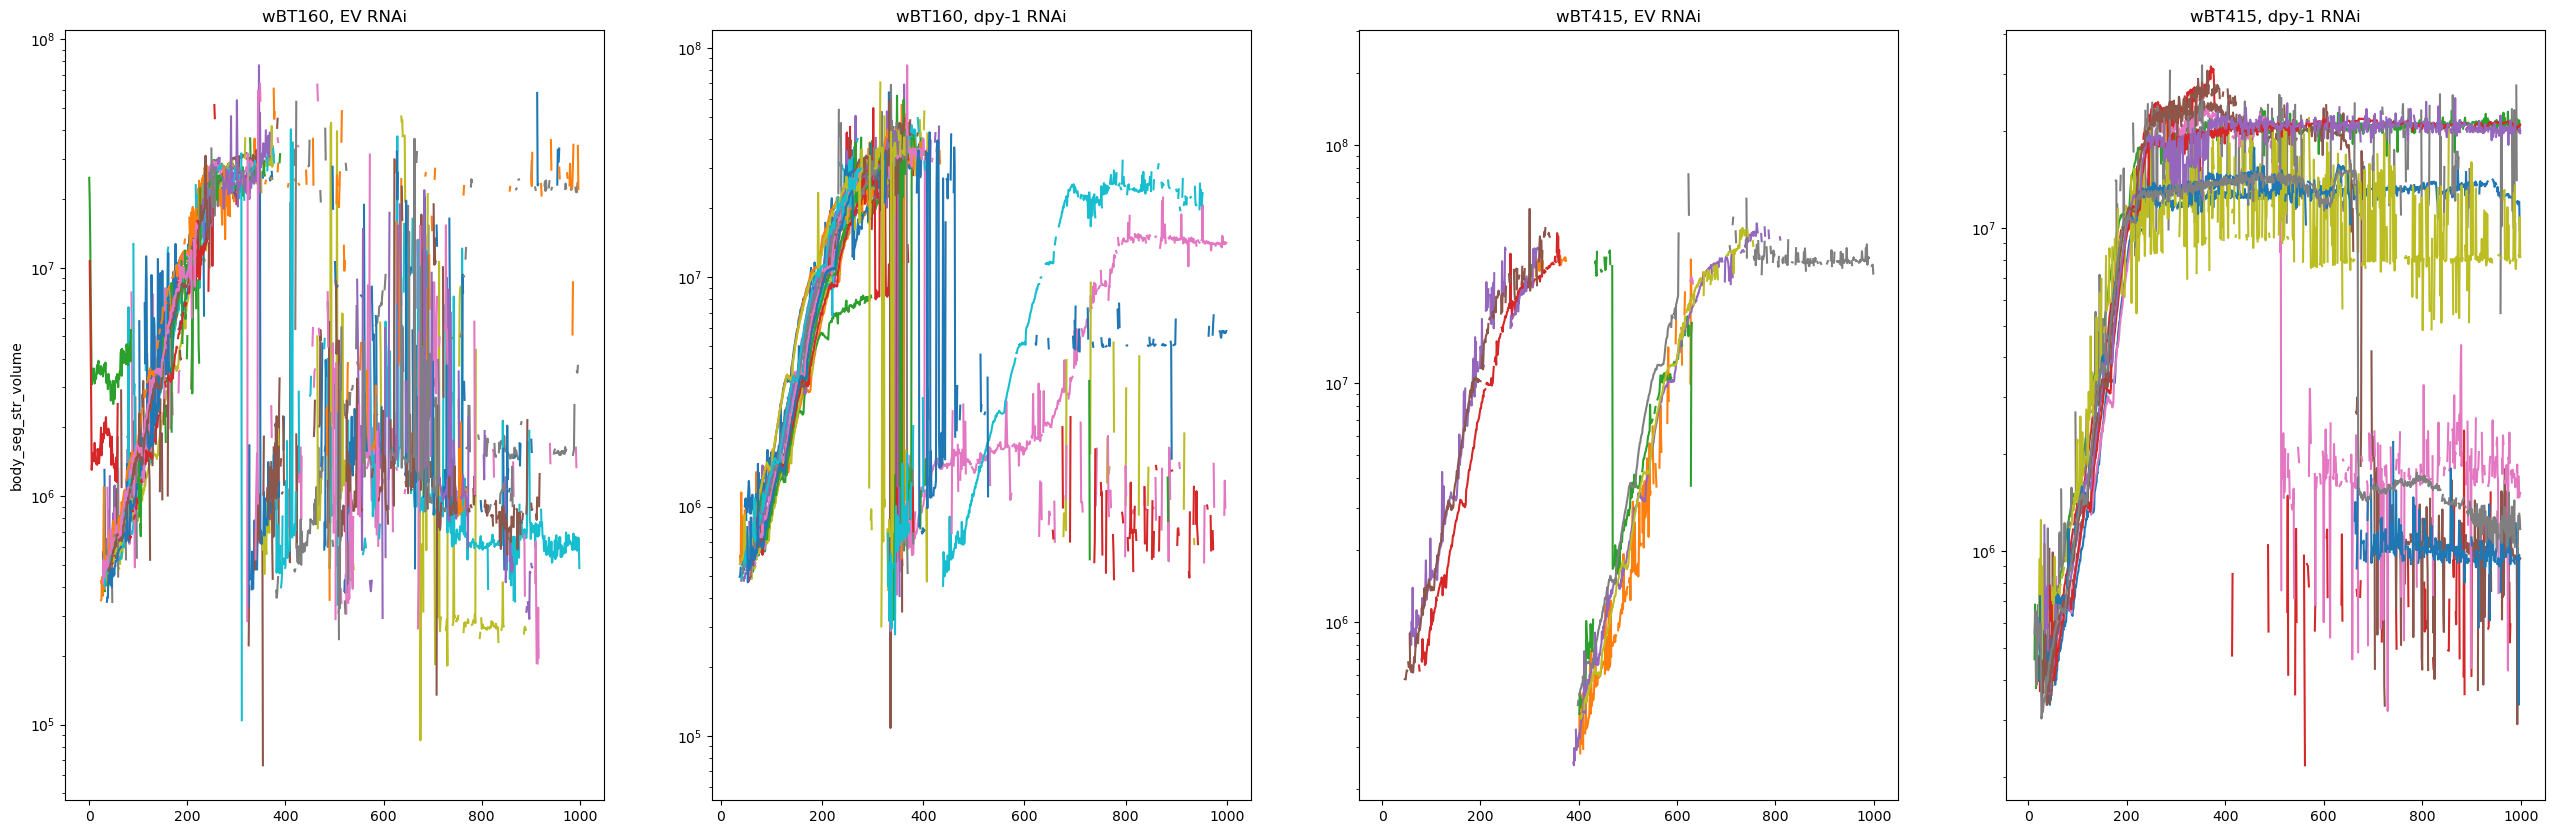

In [13]:
plot_growth_curves_individuals(conditions_struct, 'body_seg_str_volume', [0, 1, 2, 3], log_scale = True, legend = {'strain': '', 'rnai': 'RNAi'})

In [14]:
# model = get_proportion_model(conditions_struct[0]['body_seg_str_length'], conditions_struct[0]['body_seg_str_area'], conditions_struct[0]['body_seg_str_worm_type'])
# plot_deviation_from_model(conditions_struct, 'body_seg_str_length', 'body_seg_str_area', 0, [0, 1, 2, 3])

In [15]:
# plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "pharynx_seg_str_length_at_ecdysis", 0, [0, 1, 2, 3], remove_hatch=True, legend = {'strain': '', 'rnai': 'RNAi'})

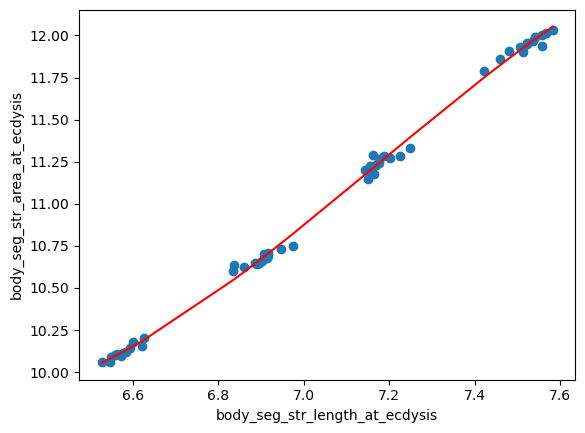

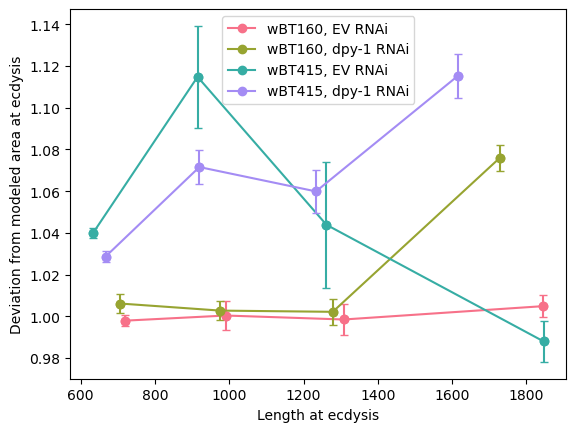

In [16]:
plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "body_seg_str_area_at_ecdysis", 0, [0, 1, 2, 3], remove_hatch=True, log_scale = False, legend = {'strain': '', 'rnai': 'RNAi'}, x_axis_label='Length at ecdysis', y_axis_label='Deviation from modeled area at ecdysis')

In [17]:
# plot_normalized_proportions(conditions_struct, 'body_seg_str_length_at_ecdysis', 'body_seg_str_area_at_ecdysis', 0, [0, 1, 2, 3], log_scale = (False, False), legend = {'strain': '', 'rnai': 'RNAi'})

In [18]:
# from typing import Union

# def compute_series_at_times_classified(series: np.ndarray, worm_types: np.ndarray, time: np.ndarray, series_time = None, medfilt_window = 7, savgol_window = 7, savgol_order = 3, bspline_order=3) -> np.ndarray:
#     """
#     Compute the series at the given time points using the worm types to classify the points. The series is first corrected for incorrect segmentation, then median filtered to remove outliers, then smoothed using a Savitzky-Golay filter, and finally interpolated using b-splines.
#     """

#     # Remove the points of non-worms from the time series and interpolate them back
#     series = correct_series_with_classification(series, worm_types)

#     # Median filter to remove outliers
#     series = medfilt(series, medfilt_window)

#     # Savitzky-Golay filter to smooth the data
#     series = savgol_filter(series, savgol_window, savgol_order)

#     # Interpolate the series using b-splines
#     if series_time is None:
#         series_time = np.arange(len(series))
#     # interpolated_series = interpolate.make_interp_spline(series_time, series, k=bspline_order)

#     # plot interpolated series and first two derivatives
#     plt.plot(np.log(series))
#     plt.show()


#     plt.plot(np.log(interpolated_series(series_time)))
#     plt.show()

#     der = interpolated_series.derivative()
#     der2 = der.derivative()

#     plt.plot(der(series_time))
#     plt.show()

#     plt.plot(der2(series_time))
#     plt.show()


# points = np.linspace(190, 230, 100)
# values = compute_series_at_times_classified(savgol_filtered, condition['body_seg_str_worm_type'][0], points, medfilt_window=7, savgol_window=7, savgol_order=5, bspline_order=3)
